<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Deconv" data-toc-modified-id="Deconv-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Deconv</a></span></li><li><span><a href="#Ensemble" data-toc-modified-id="Ensemble-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ensemble</a></span></li><li><span><a href="#MinMax-Scaling" data-toc-modified-id="MinMax-Scaling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MinMax Scaling</a></span></li><li><span><a href="#여러-이미지-minmax-scaling" data-toc-modified-id="여러-이미지-minmax-scaling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>여러 이미지 minmax scaling</a></span></li></ul></div>

In [510]:
import torch
from torch.autograd import Variable

import sys
sys.path.append('../code')

from functools import partial

import matplotlib.pyplot as plt

from utils import get_samples
from model import SimpleCNNDeconv

In [498]:
original_images_mnist, pre_images_mnist, mnist_classes, mnist_model = get_samples('mnist')

Data Complete
Model Complete


In [499]:
mnist_model = mnist_model.eval()

In [504]:
def hook(module, input, output, key):
    if isinstance(module, torch.nn.MaxPool2d):
        mnist_model.feature_maps[key] = output[0]
        mnist_model.pool_locs[key] = output[1]
    else:
        mnist_model.feature_maps[key] = output
        
for idx, layer in enumerate(mnist_model._modules.get('features')):
    layer.register_forward_hook(partial(hook, key=idx))

In [505]:
num = 5
img = pre_images_mnist[:num].clone()
print(img.size())

img = Variable(img, requires_grad=True)
outputs = mnist_model(img)
print(outputs.shape)

mnist_model.zero_grad()

grad_outputs = torch.zeros_like(outputs).scatter(1, torch.LongTensor(np.arange(num)).unsqueeze(1), 1).detach()
print(grad_outputs)

outputs.backward(gradient=grad_outputs)

print(img.grad.size())

torch.Size([5, 1, 28, 28])
torch.Size([5, 10])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
torch.Size([5, 1, 28, 28])


In [506]:
results = img.grad
print(results.size())

torch.Size([5, 1, 28, 28])


# Deconv

In [509]:
mnist_model.pool_locs[3].shape

torch.Size([5, 32, 14, 14])

In [511]:
deconv_mnist = SimpleCNNDeconv('mnist')

In [521]:
outputs = deconv_mnist(mnist_model.feature_maps[0], 0, mnist_model.pool_locs)
outputs = outputs.squeeze().detach().numpy()
print(outputs.shape)

(5, 28, 28)


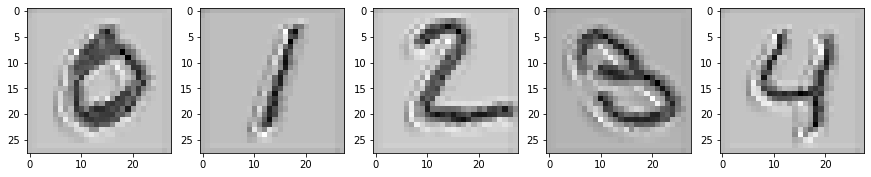

In [522]:
f, ax = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
    ax[i].imshow(outputs[i], 'gray')

# Ensemble

In [418]:
mins = pre_images_mnist.detach().numpy().min(axis=(2,3))
maxs = pre_images_mnist.detach().numpy().max(axis=(2,3))

In [431]:
mean = 0
sigma = 3
sigma = sigma / (mins - maxs)
sigma = sigma.squeeze()
print(sigma.shape)

(10,)


In [432]:
mean = np.array([mean] * sigma.shape[0])
print('mean shape: ',mean.shape)
print('sigma shape: ',sigma.shape)

mean shape:  (10,)
sigma shape:  (10,)


In [466]:
def normal_dist(img,m,std):
    return torch.zeros_like(img).normal_(m,std**2).numpy()

In [469]:
t = np.array(list(map(normal_dist, pre_images_mnist, mean, sigma)))

In [494]:
torch.Tensor(t).size()

torch.Size([10, 1, 28, 28])

# MinMax Scaling

In [495]:
results = results.numpy()

In [496]:
mins = np.min(results, axis=(1,2,3))
mins = mins.reshape(mins.shape + (1,1,))

maxs = np.max(results, axis=(1,2,3))
maxs = maxs.reshape(maxs.shape + (1,1,))

print(mins.shape)
print(maxs.shape)

(5, 1, 1)
(5, 1, 1)


In [359]:
re_results = (results - mins)/(maxs - mins)

In [360]:
for i in range(5):
    print(f'[{i}]min : ',re_results[i].min())
    print(f'[{i}]max : ',re_results[i].max())

[0]min :  0.0
[0]max :  1.0
[1]min :  0.0
[1]max :  1.0
[2]min :  0.0
[2]max :  1.0
[3]min :  0.0
[3]max :  1.0
[4]min :  0.0
[4]max :  1.0


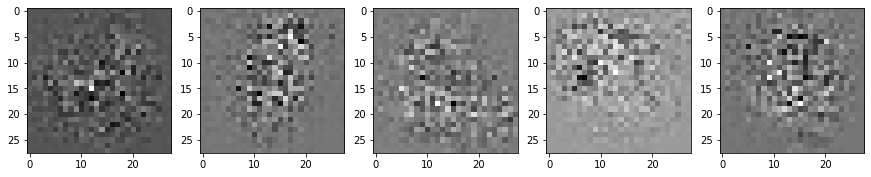

In [339]:
f, ax = plt.subplots(1,5,figsize=(15,5))
for i in range(5):
    ax[i].imshow(re_results[i].squeeze(), 'gray')

# 여러 이미지 minmax scaling

In [277]:
temp = np.array([
    [[[1,2,3],[1,2,3],[1,2,3]]],
    [[[4,5,6],[4,5,6],[4,5,6]]],
    [[[7,8,9],[7,8,9],[7,8,9]]]
])
print(temp.shape)
print(temp)

(3, 1, 3, 3)
[[[[1 2 3]
   [1 2 3]
   [1 2 3]]]


 [[[4 5 6]
   [4 5 6]
   [4 5 6]]]


 [[[7 8 9]
   [7 8 9]
   [7 8 9]]]]


In [313]:
mul = np.array([[[[1]]],[[[4]]],[[[7]]]])
print(mul.shape)
print(mul)

(3, 1, 1, 1)
[[[[1]]]


 [[[4]]]


 [[[7]]]]


In [314]:
print((temp * mul).shape)
print(temp*mul)

(3, 1, 3, 3)
[[[[ 1  2  3]
   [ 1  2  3]
   [ 1  2  3]]]


 [[[16 20 24]
   [16 20 24]
   [16 20 24]]]


 [[[49 56 63]
   [49 56 63]
   [49 56 63]]]]
